# **Stroke Prediction**

A [stroke](https://www.cdc.gov/stroke/about/index.html#:~:text=A%20stroke%2C%20sometimes%20called%20a,brain%20become%20damaged%20or%20die.), sometimes referred to as a 'brain attack,' occurs when blood flow to a part of the brain is interrupted or reduced, depriving brain tissue of oxygen and nutrients, which can lead to parts of the brain being damaged or dying within minutes. A stroke can cause permanent brain damage, long-term disability, or even death. There are two main types of stroke: ischemic, caused by a blocked artery, and hemorrhagic, caused by a burst blood vessel. Symptoms include sudden numbness or weakness, especially on one side of the body, confusion, trouble speaking, vision problems, dizziness, and severe headache. Immediate medical attention is crucial to minimize brain damage and potential complications. Stroke prevention includes managing risk factors such as high blood pressure, smoking, diabetes, and maintaining a healthy lifestyle.

Stroke is the [number five cause of death](https://www.stroke.org/en/about-stroke) and a leading cause of disability in the United States. Due to the lethal and preventative nature of the disease, it is extremely important to have methodologies in place to ensure its effective detection and management early on. This project aims to efficiently and accurately predict the incidence of stroke from patient data. It will include the training, analysis, and comparision of 5 types of machine learning algorithms: logistic regression, decision tree, random forest, extreme gradient boosting, and neural network multilayer perceptron. The [dataset](https://gist.github.com/aishwarya8615/d2107f828d3f904839cbcb7eaa85bd04) being utilized contains real-world patient data, specifically 12 indicators/risk factors of stroke.

In [360]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

### Loading Data

In [363]:
data = pd.read_csv('StrokeData.csv')
print(data)

         id  gender   age  hypertension  heart_disease ever_married  \
0      9046    Male  67.0             0              1          Yes   
1     51676  Female  61.0             0              0          Yes   
2     31112    Male  80.0             0              1          Yes   
3     60182  Female  49.0             0              0          Yes   
4      1665  Female  79.0             1              0          Yes   
...     ...     ...   ...           ...            ...          ...   
5105  18234  Female  80.0             1              0          Yes   
5106  44873  Female  81.0             0              0          Yes   
5107  19723  Female  35.0             0              0          Yes   
5108  37544    Male  51.0             0              0          Yes   
5109  44679  Female  44.0             0              0          Yes   

          work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0           Private          Urban             228.69  36.6  former

### Preprocessing Data

In [365]:
class_names = ['No Stroke', 'Stroke']

In [367]:
data['gender'].replace(['Female', 'Male', 'Other'], [0, 1, None], inplace=True)
data['ever_married'].replace(['No', 'Yes'], [0, 1], inplace=True)
data['Residence_type'].replace(['Rural', 'Urban'], [0, 1], inplace=True)
data['smoking_status'].replace(['never smoked', 'formerly smoked', 'smokes', 'Unknown'], [0, 1, 2, None], inplace=True)
data['work_type'].replace(['Self-employed', 'Private', 'Govt_job', 'children', 'Never_worked'], [0, 1, 2, 3, 4], inplace=True)

Categorical features converted into numerical features, allowing for uniform numerical input into the machine learning models.

In [371]:
data=data.drop('id', axis='columns')
data.dropna(axis=0, how='any', inplace=True)

In [373]:
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1.0,67.0,0,1,1,1,1,228.69,36.6,1.0,1
2,1.0,80.0,0,1,1,1,0,105.92,32.5,0.0,1
3,0.0,49.0,0,0,1,1,1,171.23,34.4,2.0,1
4,0.0,79.0,1,0,1,0,0,174.12,24.0,0.0,1
5,1.0,81.0,0,0,1,1,1,186.21,29.0,1.0,1


In [375]:
print("Number of training examples/patients included in dataset:", len(data.axes[0]))

Number of training examples/patients included in dataset: 3425


In [377]:
num_healthy = data['stroke'].value_counts().get(0, 0) 
num_stroke = data['stroke'].value_counts().get(1, 0)
print("Number of patients without Stroke:", num_healthy)
print("Number of patients diagnosed with Stroke:", num_stroke)

Number of patients without Stroke: 3245
Number of patients diagnosed with Stroke: 180


This dataset is highly unbalanced. An oversampling technique will be later employed in order to balance the training set and allow for accurate model training.

### Visualizing Data

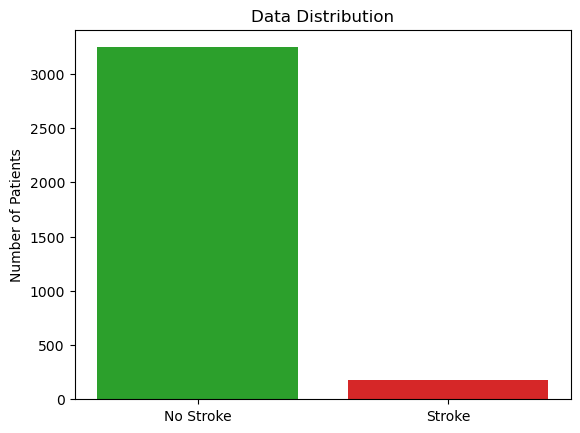

In [381]:
fig, ax = plt.subplots()

counts = [num_healthy, num_stroke]
bar_colors = ['tab:green', 'tab:red']

ax.bar(class_names, counts, label=class_names, color=bar_colors)

ax.set_ylabel('Number of Patients')
ax.set_title('Data Distribution')

plt.show()

Once again, the distribution graph illustrates how imbalanced the data is.

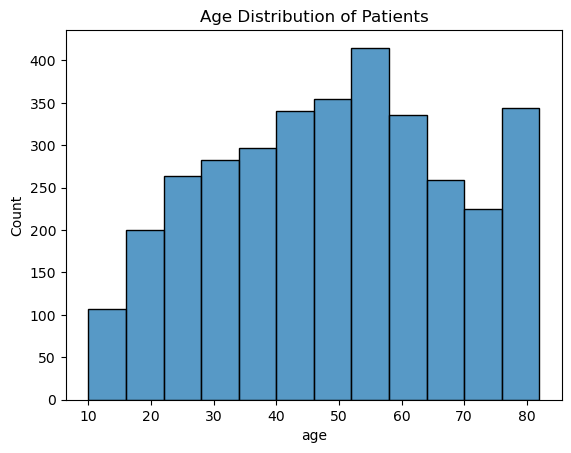

In [390]:
sns.histplot(data['age'], bins=12)
plt.title('Age Distribution of Patients')
plt.show()

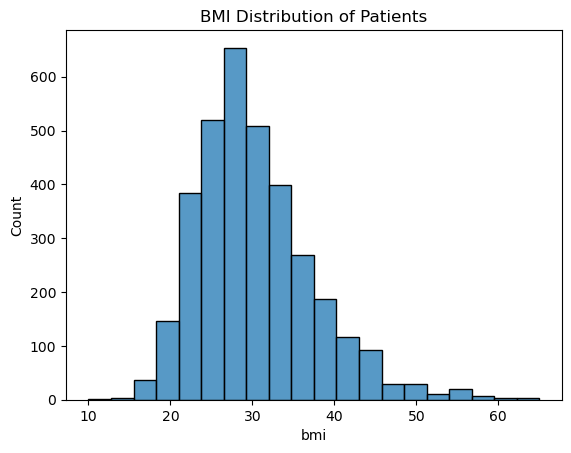

In [392]:
sns.histplot(data['bmi'], bins=20, binrange=(10, 65))
plt.title('BMI Distribution of Patients')
plt.show()

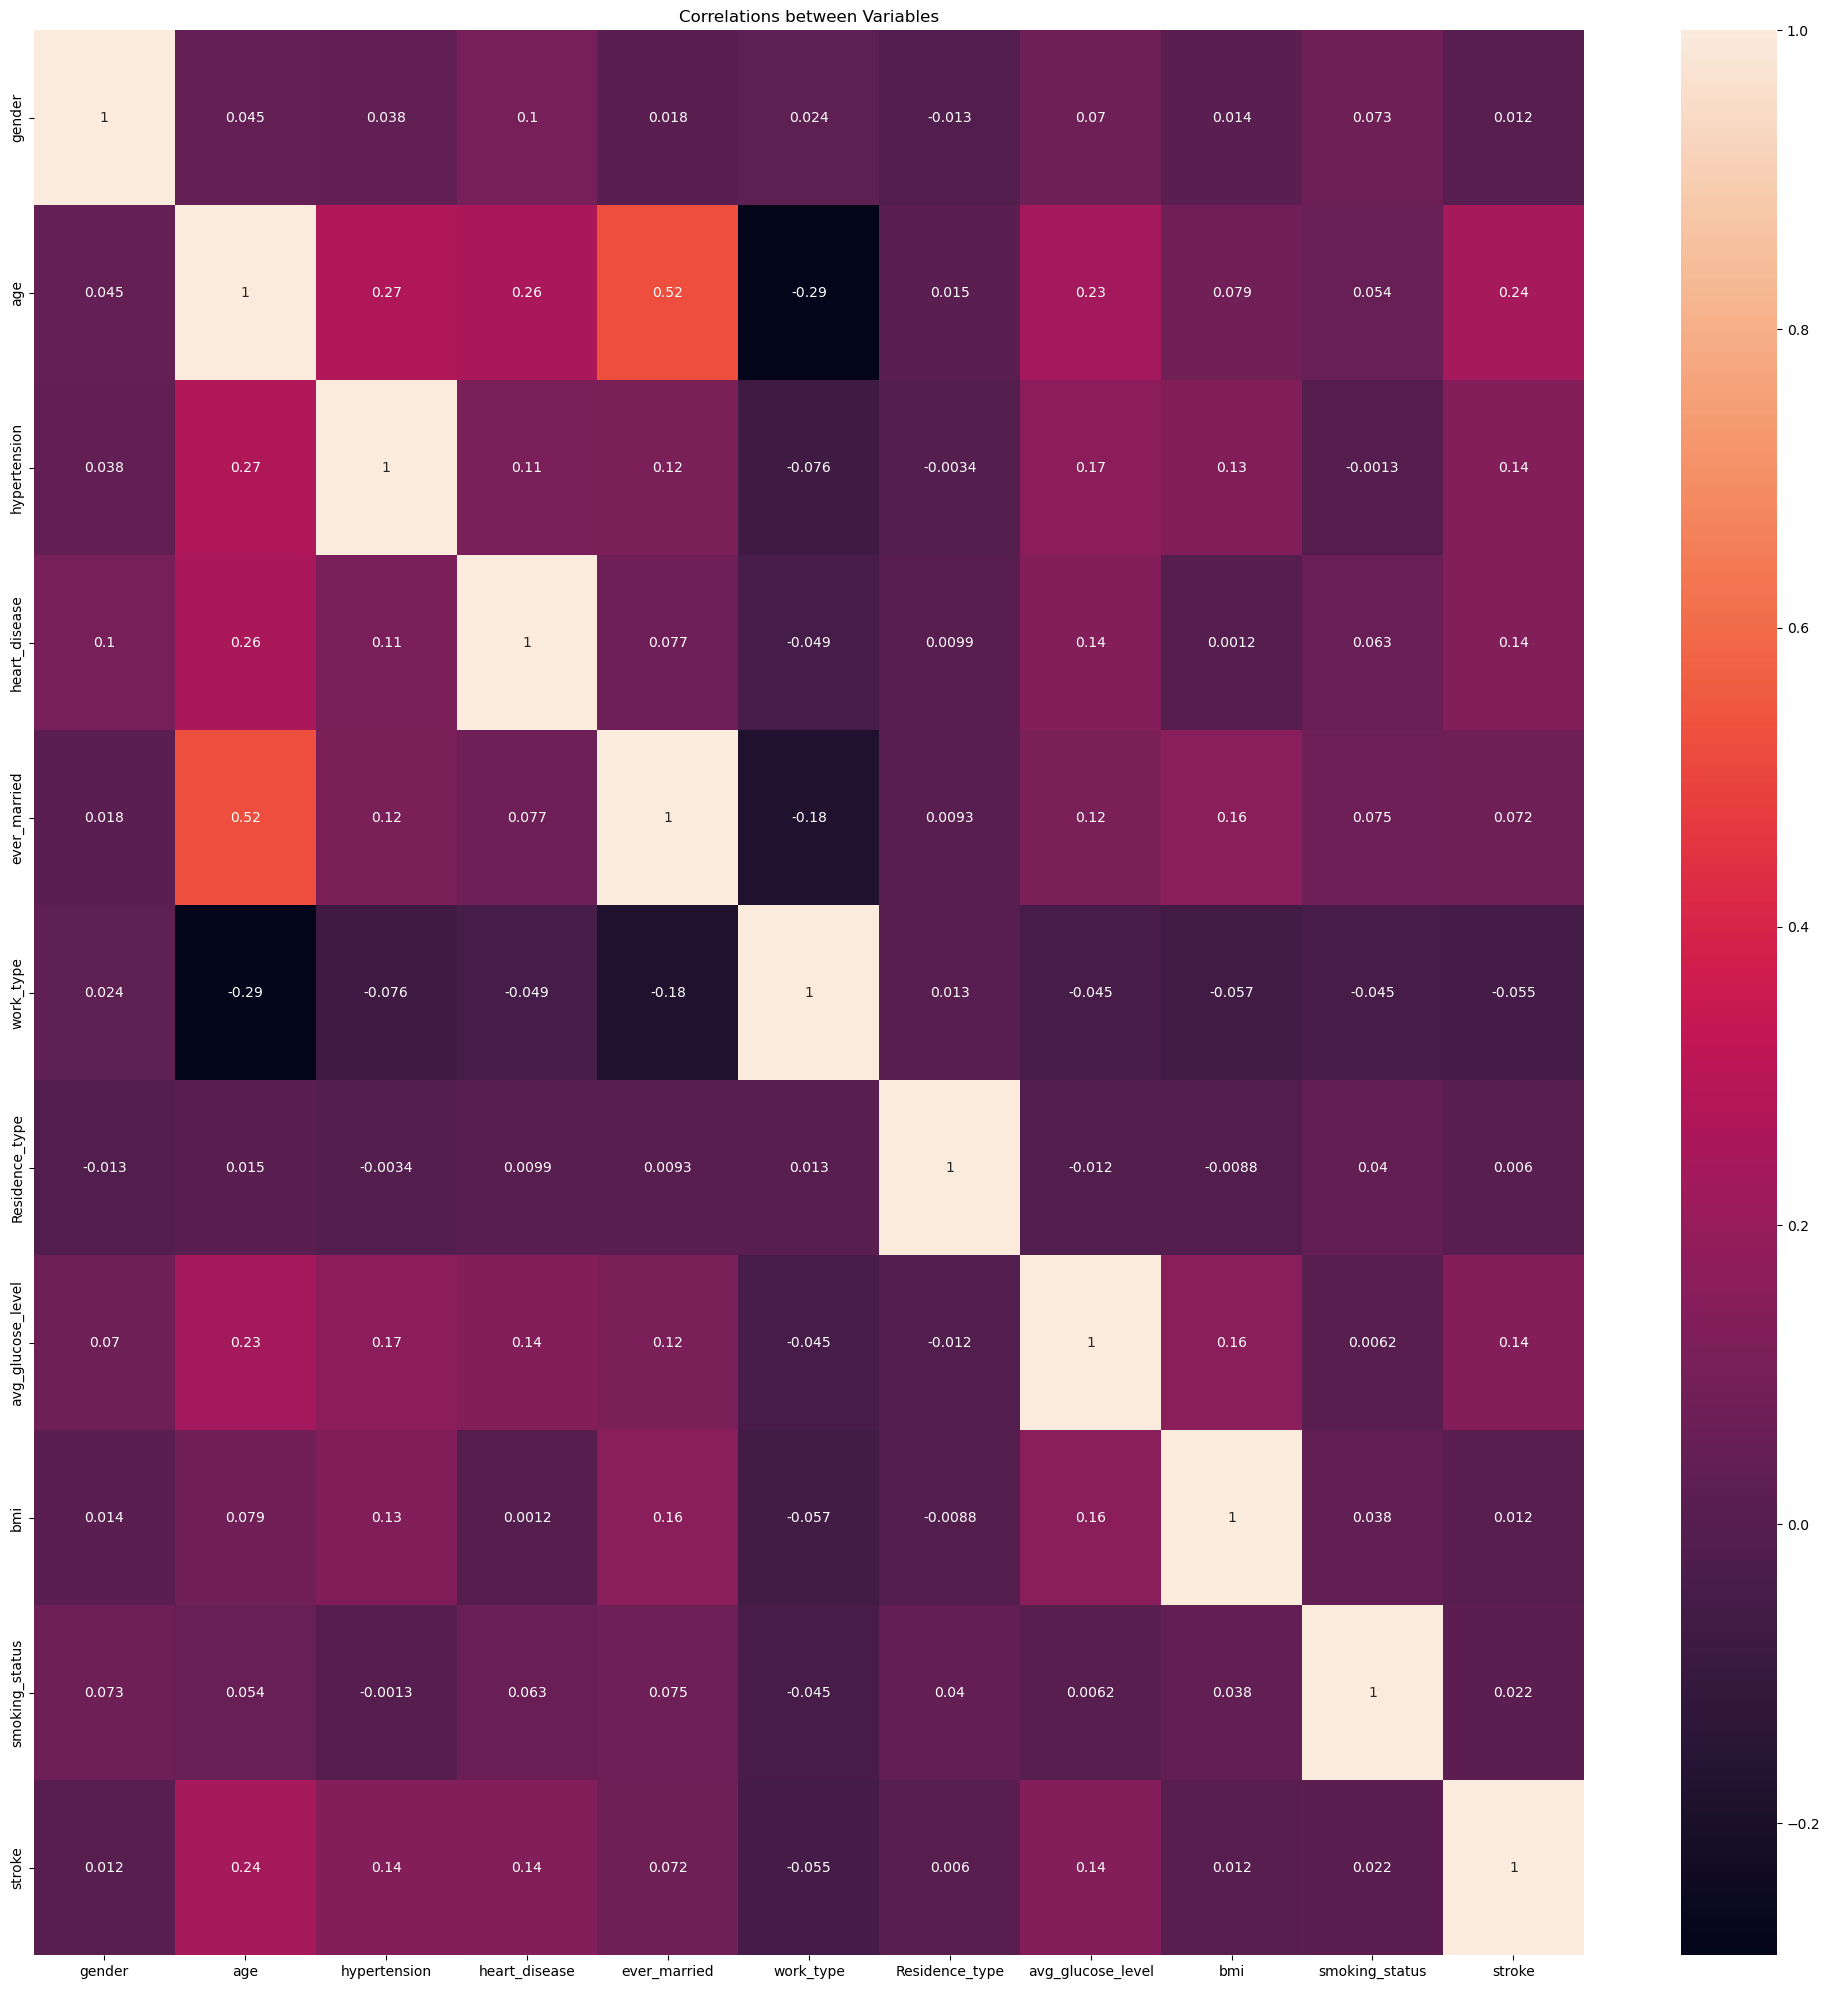

In [394]:
correlations = data.corr(numeric_only=True)
plt.subplots(figsize=(25,25))
sns.heatmap(correlations, annot=True)
plt.title('Correlations between Variables')
plt.show()

Correlation Heatmap: this is a graphical tool which presents the correlations between all variables as a color-coded matrix.

### Splitting Data

In [410]:
X_train, X_val, y_train, y_val = train_test_split(data.drop('stroke', axis=1), data['stroke'], train_size = 0.8)

Divides the images into 2 subsets:

Training set - used to train the models

Validation set - intermediary set used for fine-tuning the models and preventing overfitting; while training, it periodically helps assess how well the models generalize to data they haven't been trained on

### Balancing Training Data

SMOTE (Synthetic Minority Over-sampling Technique) is used to address the issue of class imbalance in datasets. Imbalanced datasets, such as the one being used here, can lead to poor performance, espeially in predicting the minority class. SMOTE helps by generating synthetic samples for the minority class to balance the dataset. Unlike other oversampling methods, SMOTE generates new, varied minority instances, reducing the likelihood of overfitting.

In [424]:
smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [426]:
print("Number of patients without Stroke:", len(X_train_balanced))
print("Number of patients diagnosed with Stroke:", len(y_train_balanced))

Number of patients without Stroke: 5178
Number of patients diagnosed with Stroke: 5178


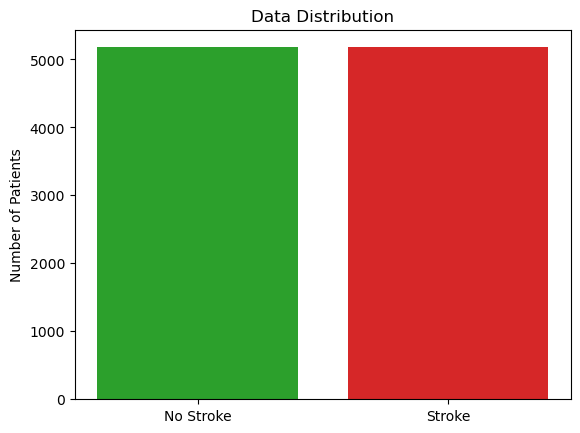

In [430]:
fig, ax = plt.subplots()

counts = [len(X_train_balanced), len(y_train_balanced)]
bar_colors = ['tab:green', 'tab:red']

ax.bar(class_names, counts, label=class_names, color=bar_colors)

ax.set_ylabel('Number of Patients')
ax.set_title('Data Distribution')

plt.show()

The training set has been synthetically balanced.

In [435]:
print(f'train samples: {len(X_train_balanced)}')
print(f'validation samples: {len(X_val)}')
print(f'target proportion: {sum(y_train_balanced)/len(y_train_balanced):.4f}')

train samples: 5178
validation samples: 685
target proportion: 0.5000


### Logistic Regression Model

Logistic regression is a basic supervised machine learning algorithm typically used for binary classification tasks and utilizes the sigmoid activation function, which takes the independent variables as input and outputs a probability value between 0 and 1, denoting which of the target classes was predicted. A decision threshold, typically 0.5, is used to classify the outcome into one of the two classes.

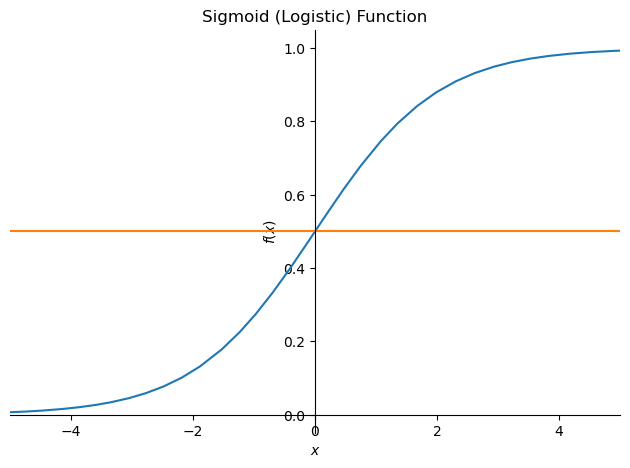

In [439]:
import sympy
sympy.plot("1/(1+exp(-x))", "0.5", xlim=(-5,5), title='Sigmoid (Logistic) Function');

In [441]:
from sklearn.linear_model import LogisticRegression

In [443]:
logistic_regression_model = LogisticRegression(max_iter=10000)
logistic_regression_model.fit(X_train_balanced, y_train_balanced)

LogisticRegression(max_iter=10000)

In [445]:
predictions = logistic_regression_model.predict(X_val)

In [449]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(logistic_regression_model.predict(X_train_balanced),y_train_balanced):.4f}")
logistic_regression_accuracy=accuracy_score(predictions,y_val)
logistic_regression_precision=precision_score(predictions,y_val)
logistic_regression_recall=recall_score(predictions,y_val)
logistic_regression_f1_score=f1_score(predictions,y_val)
logistic_regression_auc_score=roc_auc_score(predictions,y_val)
print(f"Metrics validation:\n\tAccuracy score: {logistic_regression_accuracy:.4f}")
print(f"\tPrecision: {logistic_regression_precision:.4f}")
print(f"\tRecall: {logistic_regression_recall:.4f}")
print(f"\tF1 score: {logistic_regression_f1_score:.4f}")
print(f"\tAUC score: {logistic_regression_auc_score:.4f}")

Metrics train:
	Accuracy score: 0.7949
Metrics validation:
	Accuracy score: 0.7562
	Precision: 0.7931
	Recall: 0.1250
	F1 score: 0.2160
	AUC score: 0.5565


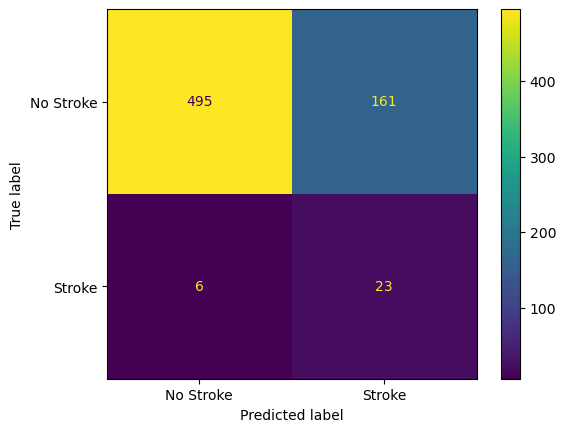

In [451]:
cm=confusion_matrix(y_true=y_val, y_pred=predictions)
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()

Confusion Matrix: also known as an error matrix, a matrix representation of model testing results allowing for the identification of classes that the algorithm is 'confusing' or misidentifying for another class(es).

### Decision Tree Model

Decision Tree classification is a supervised machine learning algorithm with works by recursively splitting the dataset into subsets based on the value of input-features, forming a tree-like structure. its components include the root node, which includes the entire dataset, decision nodes, which are the splits in the tree, and leaf nodes, which are the model's predictions. At every node, the algorithm selects the best feature to split the data and continues splitting recursively until a stopping criterion is met. Critiera used to decide which features to split on include Gini impurity and information gain.

In [456]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

In [458]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700]
max_depth_list = [1,2, 3, 4, 8, 16, 32, 64, None]

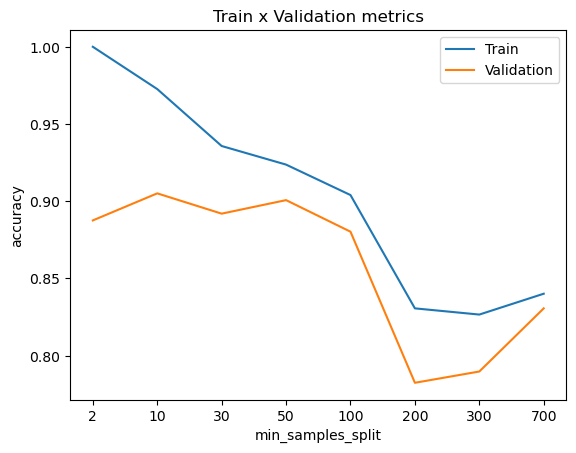

In [460]:
accuracy_list_train = []
accuracy_list_val = []
for min_samples_split in min_samples_split_list:
    model = DecisionTreeClassifier(min_samples_split = min_samples_split).fit(X_train_balanced, y_train_balanced) 
    predictions_train = model.predict(X_train) 
    predictions_val = model.predict(X_val) 
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

min_samples_split is a parameter of the decision tree algorithm and denotes the minimum number of samples required to split an internal node. Based on this graph, the optimal parameter value to use for this data seems to be 10 samples.

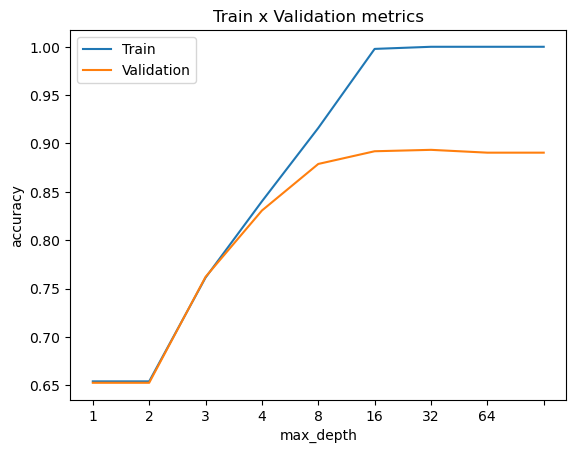

In [463]:
accuracy_list_train = []
accuracy_list_val = []
for max_depth in max_depth_list:
    model = DecisionTreeClassifier(max_depth = max_depth).fit(X_train_balanced, y_train_balanced) 
    predictions_train = model.predict(X_train) 
    predictions_val = model.predict(X_val) 
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

Max depth is a parameter of the decision tree algorithm and denotes the maximum depth at which the tree needs to stop splitting. Based on this graph, the optimal parameter value to use for this data seems to be 16 nodes.

In [466]:
decision_tree_model = DecisionTreeClassifier(min_samples_split = 10, max_depth = 16).fit(X_train_balanced, y_train_balanced)

In [468]:
predictions = decision_tree_model.predict(X_val)

In [470]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_train_balanced),y_train_balanced):.4f}")
decision_tree_accuracy=accuracy_score(predictions,y_val)
decision_tree_precision=precision_score(predictions,y_val)
decision_tree_recall=recall_score(predictions,y_val)
decision_tree_f1_score=f1_score(predictions,y_val)
decision_tree_auc_score=roc_auc_score(predictions,y_val)
print(f"Metrics validation:\n\tAccuracy score: {decision_tree_accuracy:.4f}")
print(f"\tPrecision: {decision_tree_precision:.4f}")
print(f"\tRecall: {decision_tree_recall:.4f}")
print(f"\tF1 score: {decision_tree_f1_score:.4f}")
print(f"\tAUC score: {decision_tree_auc_score:.4f}")

Metrics train:
	Accuracy score: 0.9811
Metrics validation:
	Accuracy score: 0.9022
	Precision: 0.2759
	Recall: 0.1481
	F1 score: 0.1928
	AUC score: 0.5574


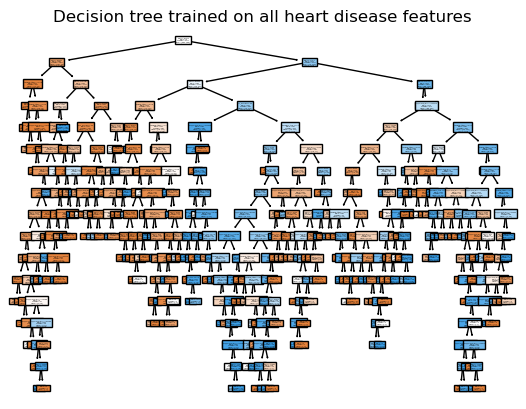

In [472]:
plt.figure()
plot_tree(decision_tree_model, filled=True, class_names=class_names, feature_names=list(data))
plt.title("Decision tree trained on all heart disease features")
plt.show()

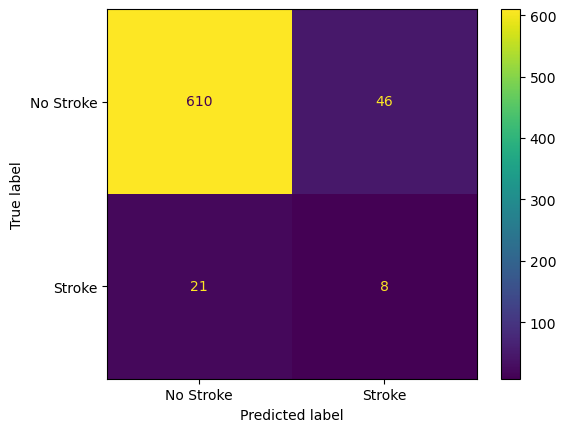

In [473]:
cm=confusion_matrix(y_true=y_val, y_pred=predictions)
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()

### Random Forest Model

Random Forest Classification is an ensemble learning method which constructs multiple decision trees during training and merges their outputs to make the final prediction. It is generally much more accurate and robust than individual decision trees.

In [478]:
from sklearn.ensemble import RandomForestClassifier

In [480]:
n_estimators_list = [10,50,100,500]

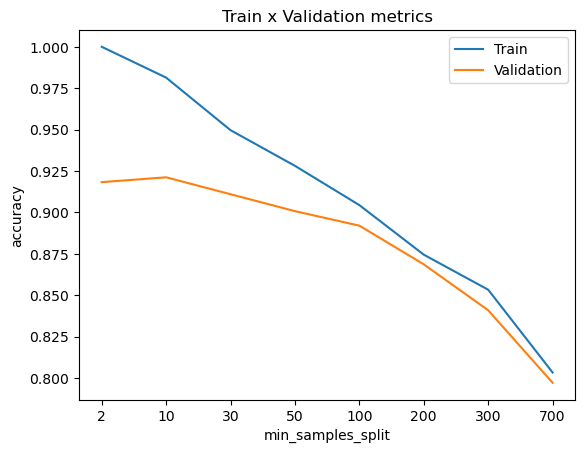

In [501]:
accuracy_list_train = []
accuracy_list_val = []
for min_samples_split in min_samples_split_list:
    model = RandomForestClassifier(min_samples_split = min_samples_split).fit(X_train_balanced,y_train_balanced) 
    predictions_train = model.predict(X_train) 
    predictions_val = model.predict(X_val) 
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list) 
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

Based on the graph, the optimal min_samples_split value to use for this data seems to be 10 samples.

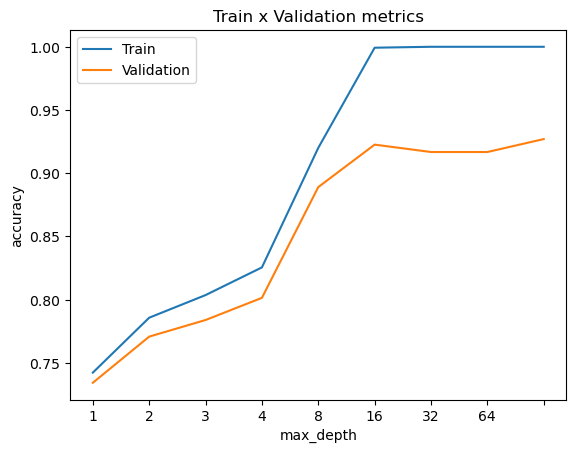

In [485]:
accuracy_list_train = []
accuracy_list_val = []
for max_depth in max_depth_list:
    model = RandomForestClassifier(max_depth = max_depth).fit(X_train_balanced,y_train_balanced) 
    predictions_train = model.predict(X_train) 
    predictions_val = model.predict(X_val) 
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

Based on the graph, the optimal max_depth value to use for this data seems to be 16 nodes.

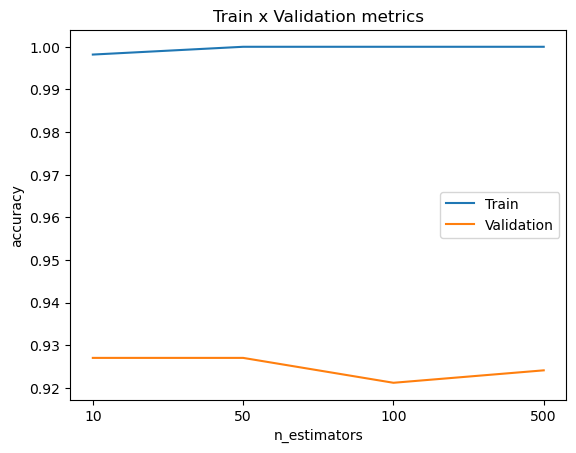

In [488]:
accuracy_list_train = []
accuracy_list_val = []
for n_estimators in n_estimators_list:
    model = RandomForestClassifier(n_estimators = n_estimators).fit(X_train_balanced,y_train_balanced) 
    predictions_train = model.predict(X_train) 
    predictions_val = model.predict(X_val) 
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(n_estimators_list )),labels=n_estimators_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

Number of estimators(n_estimators) is a parameter of the decision tree algorithm and denotes number of decision trees in the forest. Based on this graph, the optimal parameter value to use for this data seems to be 50 trees.

In [503]:
random_forest_model = RandomForestClassifier(n_estimators = 50, max_depth = 16, min_samples_split = 10).fit(X_train_balanced,y_train_balanced)

In [505]:
predictions = random_forest_model.predict(X_val)

In [507]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_train_balanced),y_train_balanced):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(predictions,y_val):.4f}")
random_forest_accuracy=accuracy_score(predictions,y_val)
random_forest_precision=precision_score(predictions,y_val)
random_forest_recall=recall_score(predictions,y_val)
random_forest_f1_score=f1_score(predictions,y_val)
random_forest_auc_score=roc_auc_score(predictions,y_val)
print(f"Metrics validation:\n\tAccuracy score: {random_forest_accuracy:.4f}")
print(f"\tPrecision: {random_forest_precision:.4f}")
print(f"\tRecall: {random_forest_recall:.4f}")
print(f"\tF1 score: {random_forest_f1_score:.4f}")
print(f"\tAUC score: {random_forest_auc_score:.4f}")

Metrics train:
	Accuracy score: 0.9894
Metrics test:
	Accuracy score: 0.9168
Metrics validation:
	Accuracy score: 0.9168
	Precision: 0.0345
	Recall: 0.0333
	F1 score: 0.0339
	AUC score: 0.4953


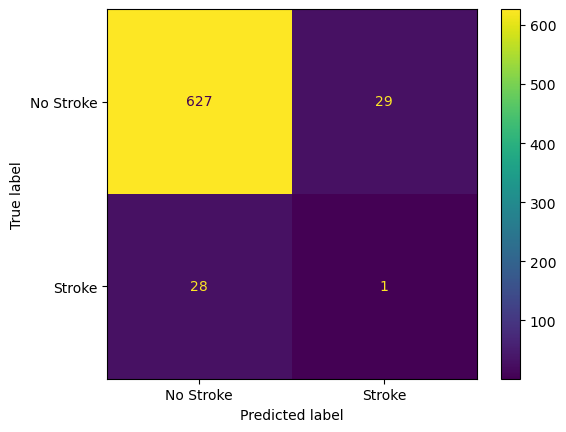

In [509]:
cm=confusion_matrix(y_true=y_val, y_pred=predictions)
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()

### XGBoost Model

XGBoost(Extreme Gradient Boosting) is an advanced implementation of the gradient boosting algorithm with builds an ensemble of decision trees in a sequential manner to optimize performance. The Boosting algorithm sequentially adds new trees that correct errors made by previous trees and gradient boosing uses gradients/erros of the loss function to build new trees that focus on hard-to-classify examples. These models are typically more efficient, accurate, and flexible than random forest classifiers.

In [515]:
from xgboost import XGBClassifier

In [517]:
n = int(len(X_train_balanced)*0.8)

In [519]:
X_train_fit, X_train_eval, y_train_fit, y_train_eval = X_train_balanced[:n], X_train_balanced[n:], y_train_balanced[:n], y_train_balanced[n:]

In [521]:
xgb_model = XGBClassifier(n_estimators = 500, learning_rate = 0.1,verbosity = 1, early_stopping_rounds = 10)
xgb_model.fit(X_train_fit,y_train_fit, eval_set = [(X_train_eval,y_train_eval)])

[0]	validation_0-logloss:0.64334
[1]	validation_0-logloss:0.59929
[2]	validation_0-logloss:0.56140
[3]	validation_0-logloss:0.52839
[4]	validation_0-logloss:0.50017
[5]	validation_0-logloss:0.47654
[6]	validation_0-logloss:0.45385
[7]	validation_0-logloss:0.43185
[8]	validation_0-logloss:0.40582
[9]	validation_0-logloss:0.38826
[10]	validation_0-logloss:0.37248
[11]	validation_0-logloss:0.35428
[12]	validation_0-logloss:0.34269
[13]	validation_0-logloss:0.32729
[14]	validation_0-logloss:0.31351
[15]	validation_0-logloss:0.30149
[16]	validation_0-logloss:0.29072
[17]	validation_0-logloss:0.28296
[18]	validation_0-logloss:0.27362
[19]	validation_0-logloss:0.26576
[20]	validation_0-logloss:0.25830
[21]	validation_0-logloss:0.25258
[22]	validation_0-logloss:0.24812
[23]	validation_0-logloss:0.24371
[24]	validation_0-logloss:0.23899
[25]	validation_0-logloss:0.23457
[26]	validation_0-logloss:0.23004
[27]	validation_0-logloss:0.22535
[28]	validation_0-logloss:0.22177
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [523]:
xgb_model.best_iteration

379

In [525]:
predictions = xgb_model.predict(X_val)

In [527]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train_balanced),y_train_balanced):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(predictions,y_val):.4f}")
xgb_accuracy=accuracy_score(predictions,y_val)
xgb_precision=precision_score(predictions,y_val)
xgb_recall=recall_score(predictions,y_val)
xgb_f1_score=f1_score(predictions,y_val)
xgb_auc_score=roc_auc_score(predictions,y_val)
print(f"Metrics validation:\n\tAccuracy score: {xgb_accuracy:.4f}")
print(f"\tPrecision: {xgb_precision:.4f}")
print(f"\tRecall: {xgb_recall:.4f}")
print(f"\tF1 score: {xgb_f1_score:.4f}")
print(f"\tAUC score: {xgb_auc_score:.4f}")

Metrics train:
	Accuracy score: 0.9983
Metrics test:
	Accuracy score: 0.9314
Metrics validation:
	Accuracy score: 0.9314
	Precision: 0.1034
	Recall: 0.1250
	F1 score: 0.1132
	AUC score: 0.5428


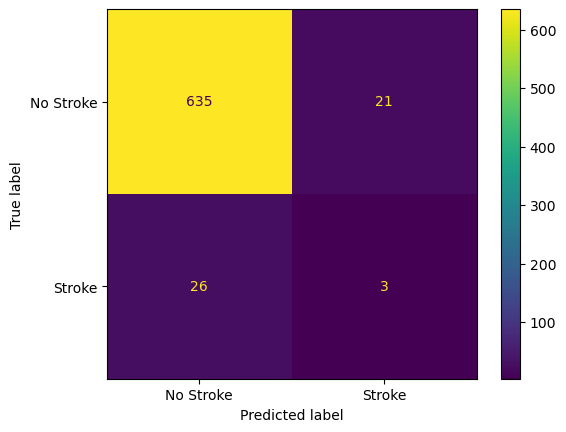

In [529]:
cm=confusion_matrix(y_true=y_val, y_pred=predictions)
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()

### Neural Network Model

Neural networks are a powerful class of machine learning algorithms consisting of interconnected layers of nodes/neurons that work together to recognize patterns and make predictions.

In [533]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler

In [535]:
features = [x for x in data.columns if x not in 'stroke']
X_train, X_temp, y_train, y_temp = train_test_split(data[features], data['stroke'], test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3)

In [537]:
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [539]:
print("Number of patients without Stroke:", len(X_train_balanced))
print("Number of patients diagnosed with Stroke:", len(y_train_balanced))

Number of patients without Stroke: 4534
Number of patients diagnosed with Stroke: 4534


In [541]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

This standard scaler standardizes the features of the dataset by removing the mean and scaling to unit variance, enruing that each feature contributes equally to the model's convergance. The standardiation transforms the data so it has a mean of 0 and a standard deviation of 1.

In [544]:
nn_model = Sequential([
Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=regularizers.l2(l=0.1)),
Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l=0.1)),
Dense(16, activation='relu'),
Dense(1, activation='sigmoid')
])

Dense Layers: regular neural network layer; 'dense' because each of its neurons are connected to every single neuron of the previous layer

Rectified Linear Unit (ReLU) Activation Function: piecewise linear function which directly outputs positive inputs and outputs zero for any non positive inputs( f(x) = max(0, x) ) 

Sigmoid Activation Function: also referred to as the logistic function, maps input values in binary classification tasks to an output range between 0 and 1; a decision threshold, typically 0.5, is used to classify the outcome into one of the two classes.

In [549]:
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

The Adam Optimizer, short for 'Adaptive Moment Estimation' is an iterative optimization algorithm which continously customizes the learning rate of each parameter based on its gradient history, allowing the algorithm to adapt as training progresses.

In [552]:
nn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                704       
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3329 (13.00 KB)
Trainable params: 3329 (13.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


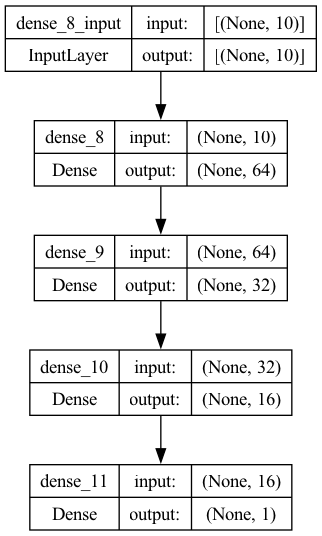

In [554]:
tf.keras.utils.plot_model(
    nn_model, to_file='model.png', show_shapes=True,
    show_layer_names=True,
)

In [574]:
my_callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)
num_epochs=50
history = nn_model.fit(X_train_scaled, y_train_balanced, epochs=num_epochs, validation_data=(X_val_scaled, y_val), callbacks=my_callbacks)

Epoch 1/50
142/142 [==============================] - 0s 971us/step - loss: 0.4649 - accuracy: 0.8072 - val_loss: 0.5879 - val_accuracy: 0.7121
Epoch 2/50
142/142 [==============================] - 0s 872us/step - loss: 0.4586 - accuracy: 0.8161 - val_loss: 0.4348 - val_accuracy: 0.8081
Epoch 3/50
142/142 [==============================] - 0s 822us/step - loss: 0.4538 - accuracy: 0.8134 - val_loss: 0.5708 - val_accuracy: 0.7246
Epoch 4/50
142/142 [==============================] - 0s 838us/step - loss: 0.4519 - accuracy: 0.8169 - val_loss: 0.5535 - val_accuracy: 0.7330
Epoch 5/50
142/142 [==============================] - 0s 829us/step - loss: 0.4495 - accuracy: 0.8200 - val_loss: 0.4416 - val_accuracy: 0.8067
Epoch 6/50
142/142 [==============================] - 0s 856us/step - loss: 0.4445 - accuracy: 0.8218 - val_loss: 0.6175 - val_accuracy: 0.6968
Epoch 7/50
142/142 [==============================] - 0s 1ms/step - loss: 0.4432 - accuracy: 0.8258 - val_loss: 0.4907 - val_accuracy: 0

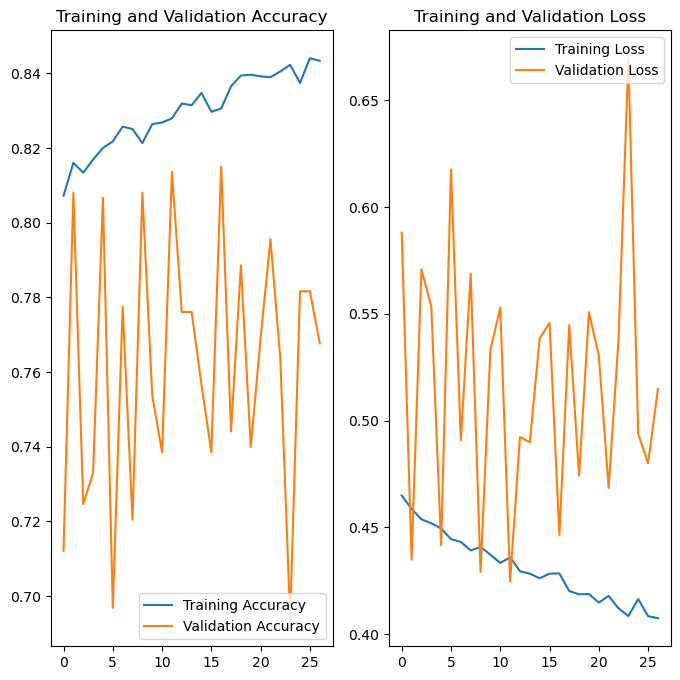

In [576]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [578]:
predictions = (nn_model.predict(X_test_scaled) > 0.5).astype(int)

10/10 [==============================] - 0s 550us/step


In [580]:
cm=confusion_matrix(y_true=y_test, y_pred=predictions)

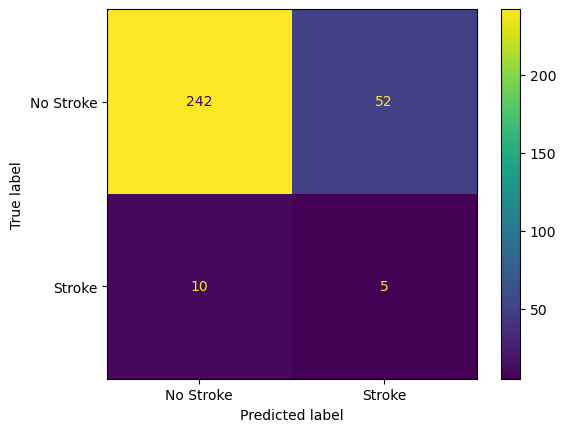

In [582]:
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()

In [584]:
cr=classification_report(y_test, predictions, target_names=class_names)
print(cr)

              precision    recall  f1-score   support

   No Stroke       0.96      0.82      0.89       294
      Stroke       0.09      0.33      0.14        15

    accuracy                           0.80       309
   macro avg       0.52      0.58      0.51       309
weighted avg       0.92      0.80      0.85       309



In [586]:
nn_accuracy=accuracy_score(predictions,y_test)
nn_precision=precision_score(predictions,y_test)
nn_recall=recall_score(predictions,y_test)
nn_f1_score=f1_score(predictions,y_test)
nn_auc_score=roc_auc_score(predictions,y_test)
print(f"Metrics validation:\n\tAccuracy score: {nn_accuracy:.4f}")
print(f"\tPrecision: {nn_precision:.4f}")
print(f"\tRecall: {nn_recall:.4f}")
print(f"\tF1 score: {nn_f1_score:.4f}")
print(f"\tAUC score: {nn_auc_score:.4f}")

Metrics validation:
	Accuracy score: 0.7994
	Precision: 0.3333
	Recall: 0.0877
	F1 score: 0.1389
	AUC score: 0.5240


### Comparing Models

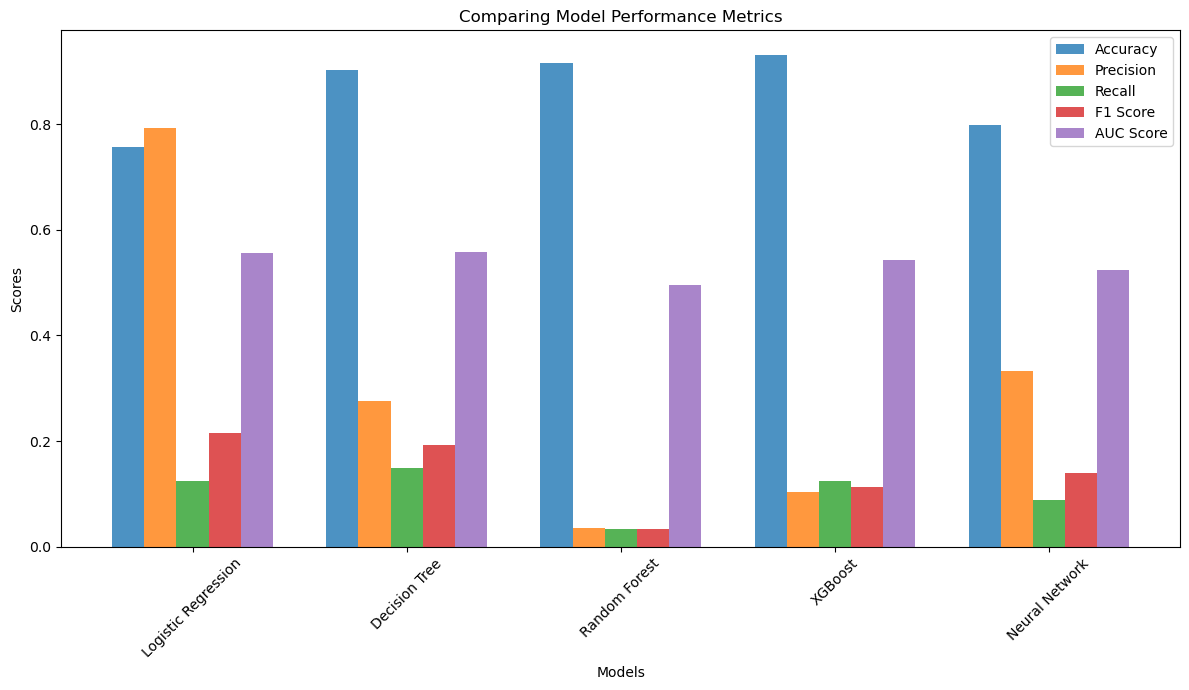

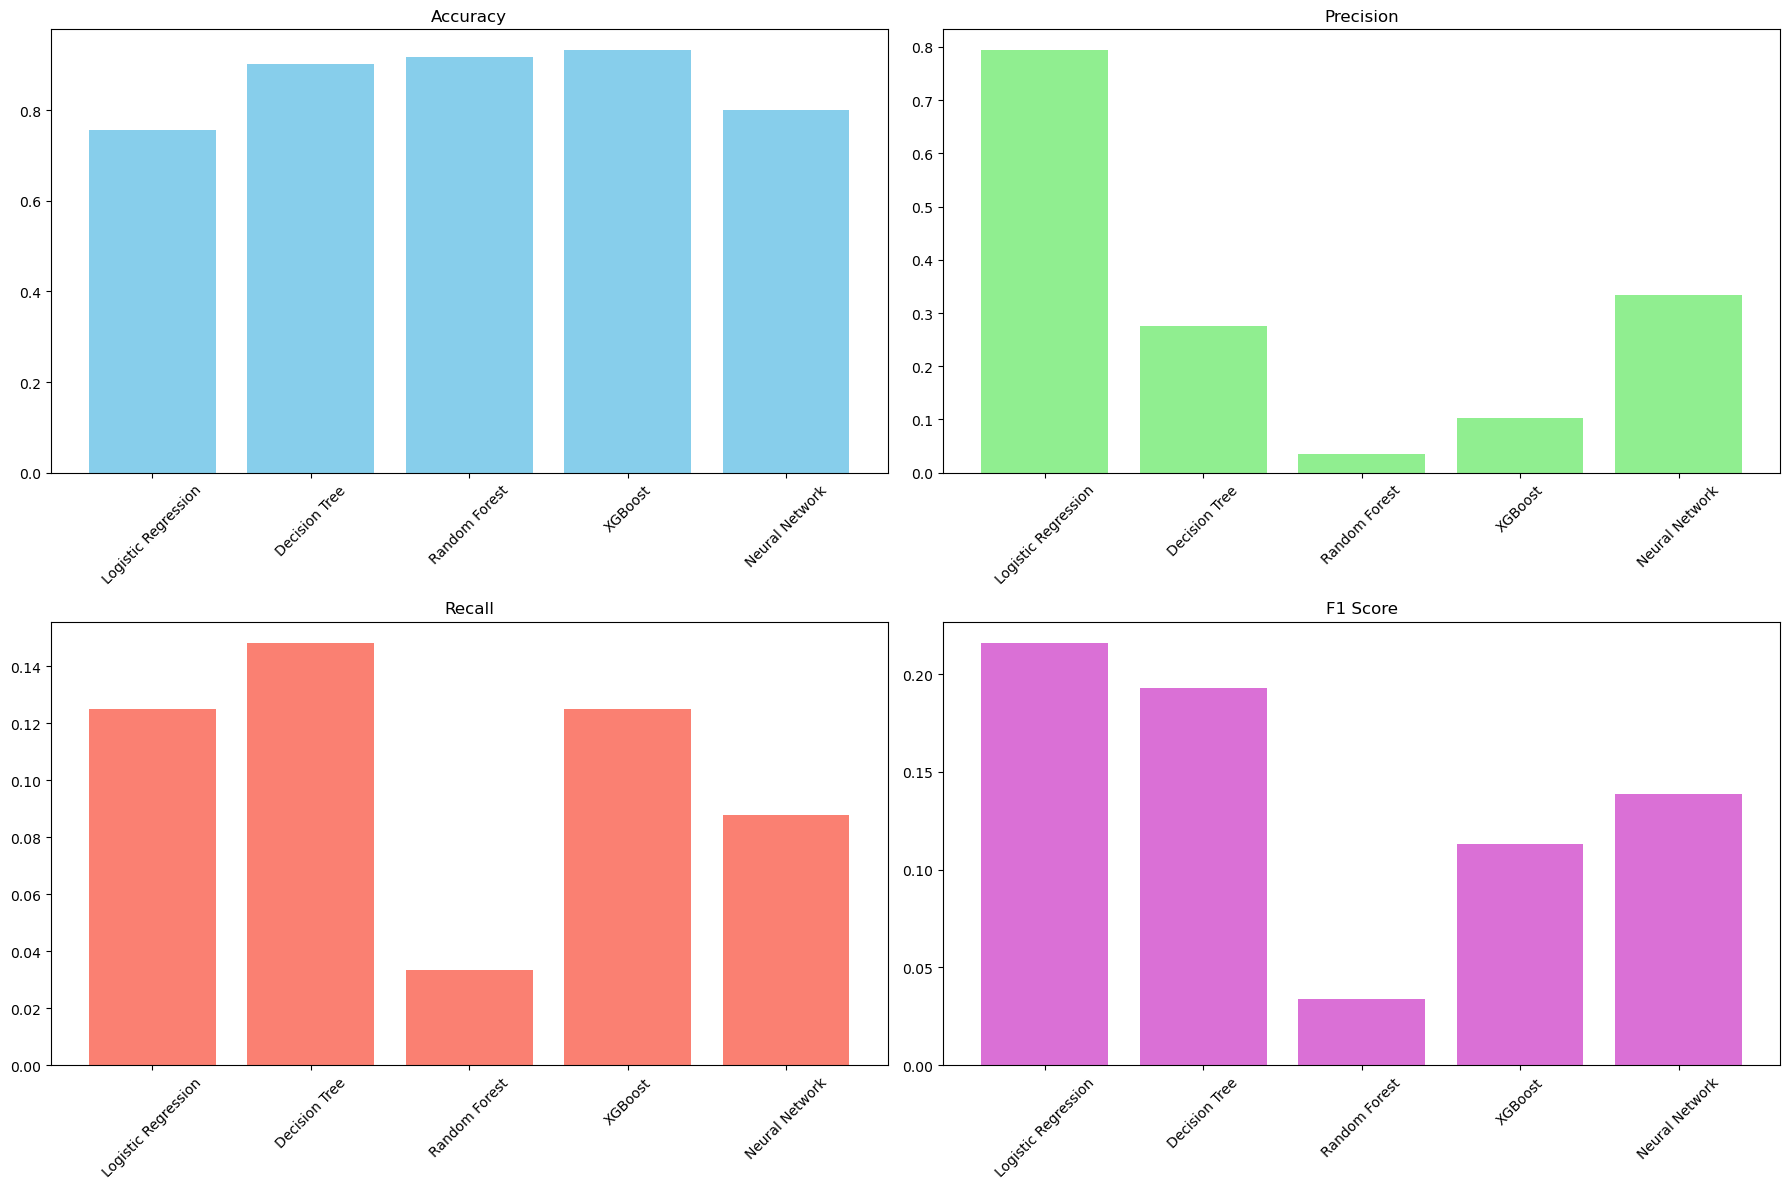

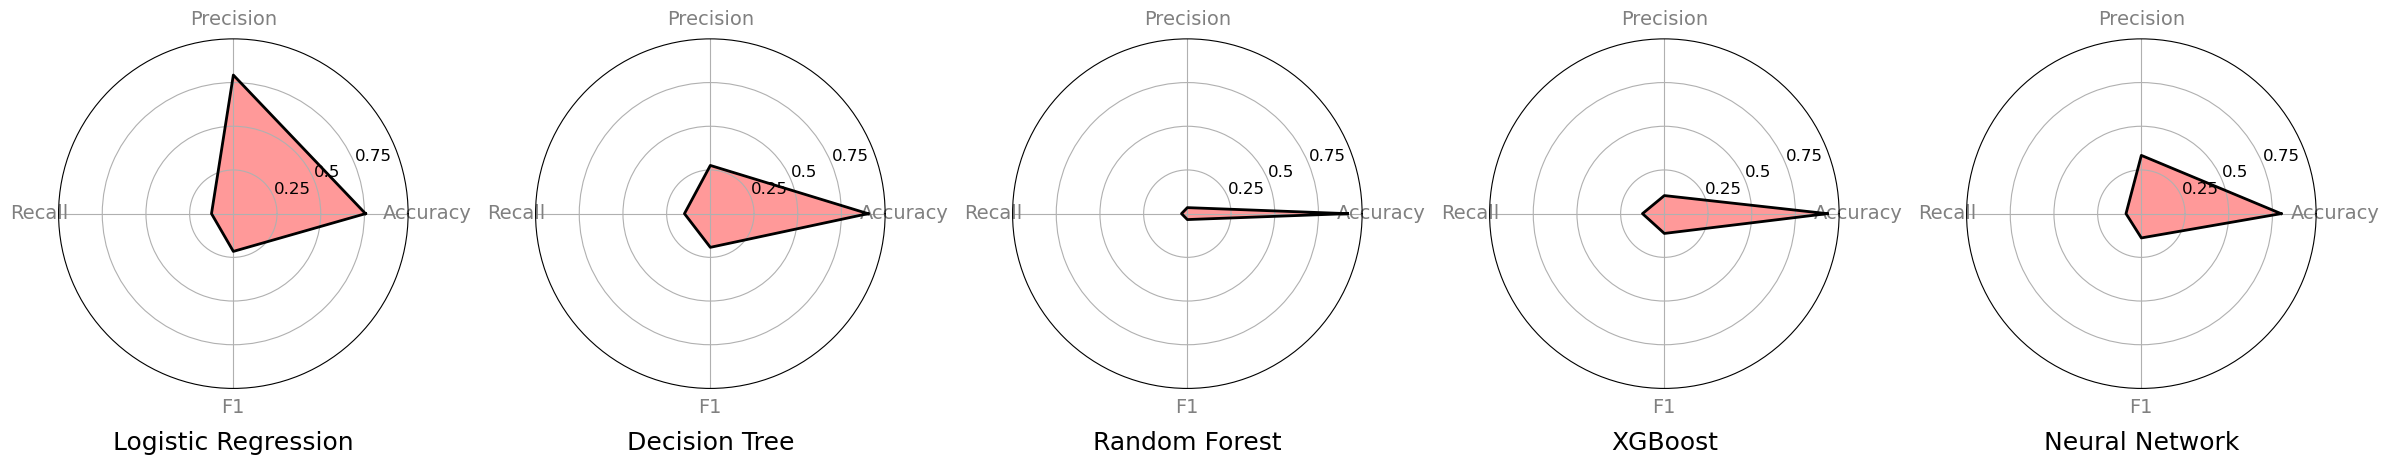

In [589]:
model_names = [
"Logistic Regression", "Decision Tree", "Random Forest", "XGBoost", "Neural Network"
]
accuracy_scores = [logistic_regression_accuracy, decision_tree_accuracy, random_forest_accuracy, xgb_accuracy, nn_accuracy]
precision_scores = [logistic_regression_precision, decision_tree_precision, random_forest_precision, xgb_precision, nn_precision]
recall_scores = [logistic_regression_recall, decision_tree_recall, random_forest_recall, xgb_recall, nn_recall]
f1_scores = [logistic_regression_f1_score, decision_tree_f1_score, random_forest_f1_score, xgb_f1_score, nn_f1_score]
AUC_scores = [logistic_regression_auc_score, decision_tree_auc_score, random_forest_auc_score, xgb_auc_score, nn_auc_score]
fig, ax = plt.subplots(figsize=(12, 7))
index_1 = np.arange(len(model_names))
bar_width = 0.15
opacity = 0.8
bar1 = ax.bar(index_1 - bar_width*2, accuracy_scores, bar_width, alpha=opacity, label='Accuracy')
bar2 = ax.bar(index_1 - bar_width, precision_scores, bar_width, alpha=opacity, label='Precision')
bar3 = ax.bar(index_1, recall_scores, bar_width, alpha=opacity, label='Recall')
bar4 = ax.bar(index_1 + bar_width, f1_scores, bar_width, alpha=opacity, label='F1 Score')
bar5 = ax.bar(index_1 + bar_width*2, AUC_scores, bar_width, alpha=opacity, label='AUC Score')
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparing Model Performance Metrics')
ax.set_xticks(index_1)
ax.set_xticklabels(model_names, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(18, 12))
axs[0, 0].bar(model_names, accuracy_scores, color='skyblue')
axs[0, 0].set_title('Accuracy')
axs[0, 0].tick_params('x', rotation=45)
axs[0, 1].bar(model_names, precision_scores, color='lightgreen')
axs[0, 1].set_title('Precision')
axs[0, 1].tick_params('x', rotation=45)
axs[1, 0].bar(model_names, recall_scores, color='salmon')
axs[1, 0].set_title('Recall')
axs[1, 0].tick_params('x', rotation=45)
axs[1, 1].bar(model_names, f1_scores, color='orchid')
axs[1, 1].set_title('F1 Score')
axs[1, 1].tick_params('x', rotation=45)
plt.tight_layout()
plt.show()

model_metrics = {
'Logistic Regression': [logistic_regression_accuracy, logistic_regression_precision, logistic_regression_recall, logistic_regression_f1_score],
'Decision Tree': [decision_tree_accuracy, decision_tree_precision,  decision_tree_recall, decision_tree_f1_score],
'Random Forest': [random_forest_accuracy, random_forest_precision, random_forest_recall, random_forest_f1_score],
'XGBoost': [xgb_accuracy, xgb_precision, xgb_recall, xgb_f1_score],
'Neural Network': [nn_accuracy, nn_precision, nn_recall, nn_f1_score],
}
def plot_model_metrics(name, scores, position): 
    metrics_df = pd.DataFrame({
        'Metrics': ['Accuracy', 'Precision', 'Recall', 'F1'],
        'Scores': scores
    })
    metrics_count = len(metrics_df['Metrics'])
    angles = np.linspace(0, 2 * np.pi, metrics_count, endpoint=False).tolist()
    angles += angles[:1]
    ax = plt.subplot(2, 5, position, polar=True)
    plt.xticks(angles[:-1], metrics_df['Metrics'], color='gray', size=14)
    plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.5", "0.75"], color="black", size=12)
    plt.ylim(0,1)
    scores += scores[:1]
    ax.plot(angles, scores, color='black', linewidth=2, linestyle='solid')
    ax.fill(angles, scores, color='red', alpha=0.4)
    plt.title(name, size=18, color='black', y=-0.2)
plt.figure(figsize=(24, 12))
chart_position = 1
for model, performance_scores in model_metrics.items():
    plot_model_metrics(model, performance_scores, chart_position)
    chart_position += 1
plt.tight_layout()
plt.show()

Accuracy is a metric used to measure how often the model correctly predicts the outcome; Acc = # Correct Predictions / # Total Predictions.

Precision: a metric which measures model performance in terms of quality; calculated as the ratio between the number of 'True Positives' and the sum of the number of 'True Positives' and the number of 'False Positives'; a high precision indicates that the model returns more relevant or 'precise' results than irrelevant ones.

Recall: a metric which measures model performance in terms of quantity; calculated as the ratio between the number of 'True Positives' and the sum of the number of 'True Positives' and the number of 'False Negatives'; a high recall indicates that the model returns most of the relevant results, regardless of how many irrelevant results are also returned.

F1-Score: measures predictive model performance by integrating precision and recall into a single metric; calculated as the harmonic mean of the precision and recall scores; ranges from 0 to 1, with 0 indicating poor performance and 1 indicating perfect performance.

AUC Score: stands for 'Area under the [ROC] curve'; the receiver operating characteristic[ROC] curve is a graph displaying the performance of a classification model at all classification thresholds, plotting the true positive rate against the false positive rate; The AUC score summarizes this curve and measures the ability of the classifier to distinguish between positive and negative classes.

Based on the visualizations, the decision tree and logistic regression models had the most optimal performances overall, while the XGBoost model had the highest validation accuracy. Low precision, recall, and F1 scores across the models reflect the heavily imbalanced validation set.